<a href="https://colab.research.google.com/github/JadeKim/Quanvolution-lab/blob/main/jade_cnn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn # basic neural network
import torch.nn.functional as F # Convolutional functions
import torch.optim as optim # optimizers
from torchvision import datasets, transforms # image datasets, image transformations

from google.colab import drive
import pandas as pd

In [3]:
torch.cuda.is_available()
torch.manual_seed(0)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(0)

In [23]:
trn_dataset = datasets.MNIST('../mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()#, # image to Tensor
                                #  transforms.Normalize((0.1307,), (0.3081,)) # mean, std of MNIST.
                             ])) 

val_dataset = datasets.MNIST("../mnist_data/", 
                             download=False,
                             train=False,
                             transform= transforms.Compose([
                               transforms.ToTensor()#,
                              #  transforms.Normalize((0.1307, ),(0.3081, ))
                           ]))

In [24]:
# Batch iterator
batch_size = 6
trn_loader = torch.utils.data.DataLoader(trn_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

In [25]:
# construct model on cuda if available
use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self, model='cnn', nl_filter=nn.Tanh()):
        super(CNNClassifier, self).__init__()
        
        nl_conv = nn.Conv2d(in_channels=1, out_channels=25, kernel_size=1) # 25@28*28
        nl_conv1 = nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5) # 50@24*24
        conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5) # 50@24*24
        pool1 = nn.MaxPool2d(2) # 50@12*12
        conv2 = nn.Conv2d(in_channels=50, out_channels=64, kernel_size=5) # 64@8*8
        pool2 = nn.MaxPool2d(2) # 64@4*4

        fc2 = nn.Linear(1024, 10)

        nn.init.xavier_uniform_(nl_conv.weight)
        nn.init.xavier_uniform_(nl_conv1.weight)
        nn.init.xavier_uniform_(conv1.weight)
        nn.init.xavier_uniform_(conv2.weight)
        nn.init.xavier_uniform_(fc2.weight)

        if model == 'random':
            self.conv_module = nn.Sequential(
                nl_conv,
                nl_filter,
                nl_conv1,
                nn.ReLU(),
                pool1,
                conv2,
                nn.ReLU(),
                pool2
            )
        else:
            self.conv_module = nn.Sequential(
                conv1,
                nn.ReLU(),
                pool1,
                conv2,
                nn.ReLU(),
                pool2
            )

        self.fc_module = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.ReLU(),
            fc2
        )
        
        # cuda
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) 
        # 64@4*4
        out = out.view(out.size(0), -1) # 1*1024
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [26]:
def save_data_file(file_name, classifier = CNNClassifier(), verbose=False, **kwargs):
  criterion = nn.CrossEntropyLoss()
  learning_rate = 1e-3
  num_epochs = 1
  
  optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
  num_batches = len(trn_loader)

  trn_loss_list = []
  val_loss_list = []
  trn_acc_list = []
  val_acc_list = []

  for epoch in range(num_epochs):
    trn_loss = 0.0
    correct = 0.0
    for i, data in enumerate(trn_loader):
      x, label = data
      if use_cuda:
        x = x.cuda()
        label = label.cuda()
      
      optimizer.zero_grad()
      
      model_output = classifier(x)
      _, predicted = torch.max(model_output.data, 1)
      
      loss = criterion(model_output, label)
      loss.backward()
      optimizer.step()
      
      trn_loss += loss.item()
      correct += (predicted == label).float().sum()/batch_size

      del loss
      del model_output
      del predicted
      
      if (i+1) % 100 == 0 or i == 0:
        with torch.no_grad():
          val_loss = 0.0
          val_correct = 0.0
          for j, val in enumerate(val_loader):
            val_x, val_label = val
            if use_cuda:
              val_x = val_x.cuda()
              val_label =val_label.cuda()
            val_output = classifier(val_x)
            _, val_predicted = torch.max(val_output.data, 1)
            v_correct = (val_predicted == val_label).float().sum()/batch_size
            v_loss = criterion(val_output, val_label)
            val_correct += v_correct
            val_loss += v_loss

        if verbose:            
          print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | trn acc: {:.4f} | val acc: {:.4f}".format(
              epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader), correct / 100, val_correct / len(val_loader)
          ))
        elif (i+1) % 1000 == 0:
          print(f'Progress: {(i+1)/num_batches:.2f} %')            
        
        trn_loss_list.append(trn_loss/100)
        val_loss_list.append(val_loss/len(val_loader))
        trn_acc_list.append(correct /100)
        val_acc_list.append(val_correct / len(val_loader))
        if i==0: continue
        trn_loss = 0.0 
        correct = 0.0

  file = pd.DataFrame(data={'trn_loss': trn_loss_list,
                            'trn_acc': trn_acc_list,
                            'val_loss': val_loss_list,
                            'val_acc': val_acc_list})
  file.to_pickle('drive/MyDrive/'+file_name)
  


In [5]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [28]:
cnn = CNNClassifier()
rand_tanh = CNNClassifier(model='random', nl_filter=nn.Tanh())
rand_sigmoid = CNNClassifier(model='random', nl_filter=nn.Sigmoid())
rand_mish = CNNClassifier(model='random', nl_filter=nn.Mish())
print(cnn)
print(rand_tanh)
print(rand_sigmoid)
print(rand_mish)

CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_module): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 1), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(50, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_module): Sequential(
    (0): Dropout(p

In [29]:
save_data_file('qlassifier_data_unit_cnn.pkl', classifier=rand_tanh, verbose=False)
save_data_file('qlassifier_data_unit_nlcnn_tanh.pkl', classifier=rand_tanh, verbose=False)
save_data_file('qlassifier_data_unit_nlcnn_sigmoid.pkl', classifier=rand_sigmoid, verbose=False)
save_data_file('qlassifier_data_unit_nlcnn_mish.pkl', classifier=rand_mish, verbose=False)

Progress: 0.10 %
Progress: 0.20 %
Progress: 0.30 %
Progress: 0.40 %
Progress: 0.50 %
Progress: 0.60 %
Progress: 0.70 %
Progress: 0.80 %
Progress: 0.90 %
Progress: 1.00 %
Progress: 0.10 %
Progress: 0.20 %
Progress: 0.30 %
Progress: 0.40 %
Progress: 0.50 %
Progress: 0.60 %
Progress: 0.70 %
Progress: 0.80 %
Progress: 0.90 %
Progress: 1.00 %
Progress: 0.10 %
Progress: 0.20 %
Progress: 0.30 %
Progress: 0.40 %
Progress: 0.50 %
Progress: 0.60 %
Progress: 0.70 %
Progress: 0.80 %
Progress: 0.90 %
Progress: 1.00 %
Progress: 0.10 %
Progress: 0.20 %
Progress: 0.30 %
Progress: 0.40 %
Progress: 0.50 %
Progress: 0.60 %
Progress: 0.70 %
Progress: 0.80 %
Progress: 0.90 %
Progress: 1.00 %


In [6]:
cnn_data = pd.read_pickle('drive/MyDrive/qlassifier_data_unit_cnn.pkl')
nlcnn_tanh_data = pd.read_pickle('drive/MyDrive/qlassifier_data_unit_nlcnn_tanh.pkl')
nlcnn_sigmoid_data = pd.read_pickle('drive/MyDrive/qlassifier_data_unit_nlcnn_sigmoid.pkl')
nlcnn_mish_data = pd.read_pickle('drive/MyDrive/qlassifier_data_unit_nlcnn_mish.pkl')

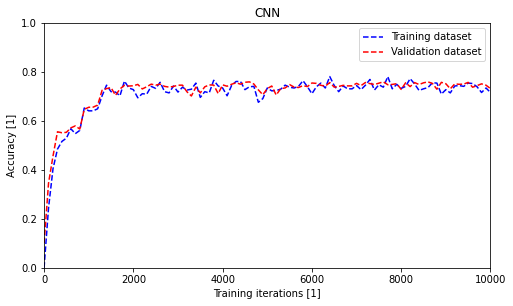

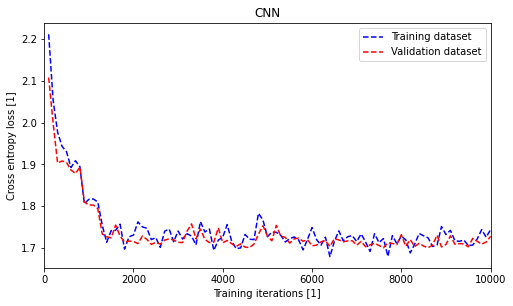

In [ ]:
# datafile = cnn_data
# datafile = nlcnn_tanh_data
# datafile = nlcnn_sigmoid_data
datafile = nlcnn_mish_data

plt.figure(1, figsize=(8,4.5))
plt.plot(datafile['trn_acc'], label="Training dataset", color='blue', linestyle='--')
plt.plot(datafile['val_acc'], label="Validation dataset", color='red', linestyle='--')
plt.title('CNN')
plt.legend()
plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100],[0, 2000, 4000, 6000, 8000, 10000])
plt.ylim(0, 1)
plt.xlabel("Training iterations [1]")
plt.ylabel("Accuracy [1]")

plt.figure(2, figsize=(8,4.5))
plt.plot(datafile['trn_loss'][1:], label="Training dataset", color='blue', linestyle='--')
plt.plot(datafile['val_loss'][1:], label="Validation dataset", color='red', linestyle='--')
plt.title('CNN')
plt.legend()
plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100],[0, 2000, 4000, 6000, 8000, 10000])
# plt.ylim(0, 1)
plt.xlabel("Training iterations [1]")
plt.ylabel("Cross entropy loss [1]")
plt.show()

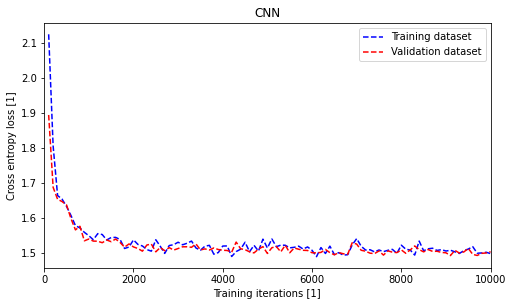

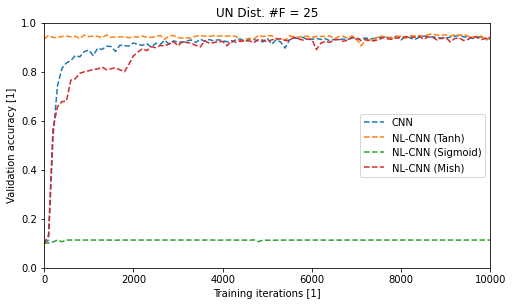

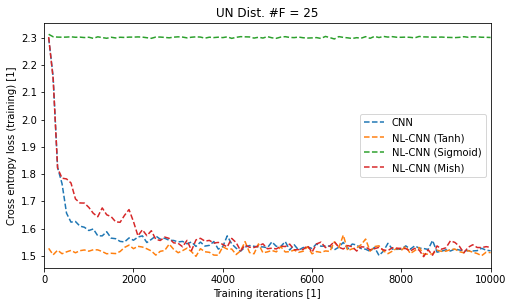

In [7]:
plt.figure(3, figsize=(8,4.5))
plt.plot(cnn_data['val_acc'], label="CNN", linestyle='--')
plt.plot(nlcnn_tanh_data['val_acc'], label="NL-CNN (Tanh)", linestyle='--')
plt.plot(nlcnn_sigmoid_data['val_acc'], label="NL-CNN (Sigmoid)", linestyle='--')
plt.plot(nlcnn_mish_data['val_acc'], label="NL-CNN (Mish)", linestyle='--')
plt.legend()
plt.title('UN Dist. #F = 25')
plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100],[0, 2000, 4000, 6000, 8000, 10000])
plt.ylim(0, 1)
plt.xlabel("Training iterations [1]")
plt.ylabel("Validation accuracy [1]")

plt.figure(4, figsize=(8,4.5))
plt.plot(cnn_data['trn_loss'][1:], label="CNN", linestyle='--')
plt.plot(nlcnn_tanh_data['trn_loss'][1:], label="NL-CNN (Tanh)", linestyle='--')
plt.plot(nlcnn_sigmoid_data['trn_loss'][1:], label="NL-CNN (Sigmoid)", linestyle='--')
plt.plot(nlcnn_mish_data['trn_loss'][1:], label="NL-CNN (Mish)", linestyle='--')
plt.legend()
plt.title('UN Dist. #F = 25')
plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100],[0, 2000, 4000, 6000, 8000, 10000])
# plt.ylim(0, 1)
plt.xlabel("Training iterations [1]")
plt.ylabel("Cross entropy loss (training) [1]")
plt.show()